# Rasterizing vectors & vectorizing rasters <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2_annual_summary](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_annual_summary)

## Background

Many remote sensing and/or geospatial workflows require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an `xarray.DataArray`).
For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description
In this notebook, we show how to use the Digital Earth Africa function `xr_rasterize` and `xr_vectorize` in [deafrica_spatialtools.py](../Scripts/deafrica_spatialtools.py). The notebook demonstrates how to:

1. Load in data from the [Water Observations from Space (WOfS)](https://maps.digitalearth.africa/#share=s-jENTWtaN98vMumZGcwM2iZXzFBo) product
2. Vectorise the pixel-based `xarray.DataArray` WOfS object into a vector-based `geopandas.GeoDataFrame` object containing persistent water-bodies as polygons
3. Export the `geopandas.GeoDataFrame` as a shapefile
4. Rasterize the `geopandas.GeoDataFrame` vector data back into an `xarray.DataArray` object and export the results as a GeoTIFF

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import sys
import datacube

sys.path.append('../Scripts')
from deafrica_datahandling import mostcommon_crs
from deafrica_spatialtools import xr_vectorize, xr_rasterize

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Rasterize_vectorize')

## Load WOfS data from the datacube

We will load in an annual summary from the Water Observations from Space (WOfS) product to provide us with some data to work with.

In [3]:
#enter a location
lat, lon = 13.50, -15.42
buffer = 0.2

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2017')
}
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load WoFS through the datacube
ds = dc.load(product='ga_ls8c_wofs_2_annual_summary', 
             output_crs=output_crs,
             align=(15, 15),
             resolution=(-30, 30),
             **query)

print(ds)


<xarray.Dataset>
Dimensions:      (time: 1, x: 1447, y: 1478)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-02T11:59:59.999500
  * y            (y) float64 1.515e+06 1.515e+06 1.515e+06 ... 1.47e+06 1.47e+06
  * x            (x) float64 4.328e+05 4.329e+05 ... 4.762e+05 4.762e+05
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 11 11 11 11 11 12 12 ... 11 11 11 11 11 11
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      epsg:32628


### Plot the WOfS summary

Let's plot the WOfS data to get an idea of the objects we will be transforming. 
In the code below, we first select the pixels where the satellite has observed water at least 25% of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorize the raster.

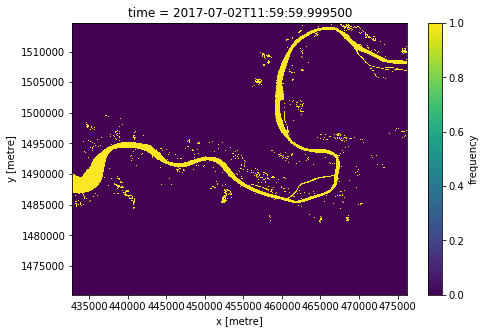

In [4]:
# Select pixels that are classified as water > 25 % of the year
water_bodies = ds.frequency > 0.25

# Plot the data
water_bodies.plot(size=5)

## Vectorizing an `xarray.DataArray`

To convert our `xarray.DataArray` object into a vector based `geopandas geodataframe`, we can use the DE Africa function `xr_vectorize` in the script [deafrica_spatialtools.py](../Scripts/deafrica_spatialtools.py). This tool is based on the [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) function, and can accept any of the arguments in `rasterio.features.shape` using the same syntax.

In the cell below, we use the argument `mask=water_bodies.values==1` to indicate we only want to convert the values in the xarray object that are equal to 1.


> **Note**: Both `xr_rasterize` and `xr_vectorize` will attempt to automatically obtain the `crs` and `transform` from the input data, but if the data does not contain this information, you will need to manually provide this.  In the cell below, we will get the `crs` and `transform` from the original dataset.

In [5]:
gdf = xr_vectorize(water_bodies,
                   crs=ds.crs,
                   transform=ds.geobox.transform,
                   mask=water_bodies.values==1)

print(gdf.head())


   attribute                                           geometry
0        1.0  POLYGON ((465945.000 1514655.000, 465945.000 1...
1        1.0  POLYGON ((466035.000 1514655.000, 466035.000 1...
2        1.0  POLYGON ((466245.000 1514655.000, 466245.000 1...
3        1.0  POLYGON ((467205.000 1514655.000, 467205.000 1...
4        1.0  POLYGON ((466155.000 1514625.000, 466155.000 1...


### Plot our vectorised raster 

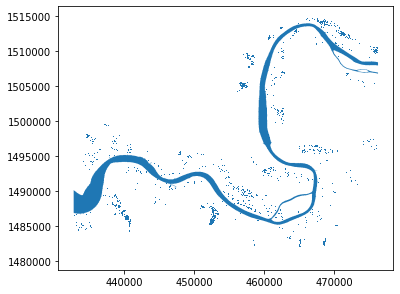

In [6]:
gdf.plot(figsize=(6, 6))

### Export as shapefile

Our function also allows us to very easily export the `GeoDataFrame` as a `shapefile` for use in other applications using the `export_shp` parameter.

In [7]:
gdf = xr_vectorize(da=water_bodies,
                   crs=ds.crs,
                   transform=ds.geobox.transform,
                   mask=water_bodies.values == 1.,
                   export_shp='test.shp')

## Rasterizing a shapefile

Using the `xr_rasterize` function in [deafrica_spatialtools.py](../Scripts/deafrica_spatialtools.py) (based on the rasterio function: [rasterio.features.rasterize](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), and can accept any of the arguments in `rasterio.features.rasterize` using the same syntax) we can turn the `geopandas.GeoDataFrame` back into a `xarray.DataArray`. 

As we already have the `GeoDataFrame` loaded we don't need to read in the shapefile, but if we wanted to read in a shapefile first we can use [gpd.read_file()](http://geopandas.org/reference/geopandas.read_file.html).   

This function uses an `xarray.dataArray` object as a **template** for converting the `geodataframe` into a raster object (the template provides the `size`, `crs`, `dimensions`, `transform`, and `attributes` of the output array).

In [8]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  transform=ds.geobox.transform,
                                  crs=ds.crs)

print(water_bodies_again)


Rasterizing to match xarray.DataArray dimensions (1478, 1447) and projection system/CRS (e.g. epsg:32628)
<xarray.DataArray (y: 1478, x: 1447)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 1.515e+06 1.515e+06 1.515e+06 ... 1.47e+06 1.47e+06
  * x        (x) float64 4.328e+05 4.329e+05 4.329e+05 ... 4.762e+05 4.762e+05
Attributes:
    crs:      epsg:32628


### Export as GeoTIFF

`xr_rasterize` also allows for exporting the results as a GeoTIFF using the parameter `export_tiff`.  To do this, a `named` array is required. If one is not provided, the functon wil provide a default one.

In [9]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  transform=ds.geobox.transform,
                                  crs=ds.crs,
                                  export_tiff='test.tif')

Rasterizing to match xarray.DataArray dimensions (1478, 1447) and projection system/CRS (e.g. epsg:32628)
Exporting GeoTIFF with default array name: 'data'


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.7+130.g81bed714.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)